In [2]:
import os
os.listdir()

['app.ipynb', 'dataset']

In [3]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
data=pd.read_csv("dataset/description.txt")
data

,Train data:
0,ID ::: TITLE ::: GENRE ::: DESCRIPTION
1,ID ::: TITLE ::: GENRE ::: DESCRIPTION
2,ID ::: TITLE ::: GENRE ::: DESCRIPTION
3,ID ::: TITLE ::: GENRE ::: DESCRIPTION
4,Test data:
5,ID ::: TITLE ::: DESCRIPTION
6,ID ::: TITLE ::: DESCRIPTION
7,ID ::: TITLE ::: DESCRIPTION
8,ID ::: TITLE ::: DESCRIPTION
9,Source:


<h1>1. Read or Extract data</h1>

In [4]:
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = f.readlines()
    data = [line.strip().split(' ::: ') for line in data]
    return data


In [5]:
train_data = load_data("dataset/train_data.txt")
train_df = pd.DataFrame(train_data, columns=['ID', 'Title', 'Genre', 'Description'])

test_data = load_data("dataset/test_data_solution.txt")
test_df = pd.DataFrame(test_data, columns=['ID', 'Title', 'Genre', 'Description'])

In [6]:
train_df


,ID,Title,Genre,Description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


<h1>2. Read or Extract data</h1>

<h3>2.1 Removing Unless Genre</h3>

In [7]:
genres_to_drop = ["fantasy", "horror", "sci-fi"]

# Hapus baris pada train_df
train_df = train_df[~train_df['Genre'].str.lower().isin([g.lower() for g in genres_to_drop])].reset_index(drop=True)

# Hapus baris pada test_df
test_df = test_df[~test_df['Genre'].str.lower().isin([g.lower() for g in genres_to_drop])].reset_index(drop=True)

print("Jumlah data setelah filtering:")
print("Train:", len(train_df))
print("Test :", len(test_df))

Jumlah data setelah filtering:
Train: 51040
Test : 51028


<h3>2.2 Combining Title & Description</h3>

In [8]:
# Gabungkan Title dan Description menjadi satu kolom baru "Text"
train_df["Text"] = train_df["Title"].astype(str) + " " + train_df["Description"].astype(str)
test_df["Text"] = test_df["Title"].astype(str) + " " + test_df["Description"].astype(str)

# (Opsional) kalau sudah tidak butuh Title dan Description, bisa di-drop
# train_df = train_df.drop(columns=["Title", "Description"])
# test_df = test_df.drop(columns=["Title", "Description"])

print(train_df[["ID", "Genre", "Text"]].head())
print(test_df[["ID", "Genre", "Text"]].head())


  ID     Genre                                               Text
0  1     drama  Oscar et la dame rose (2009) Listening in to a...
1  2  thriller  Cupid (1997) A brother and sister with a past ...
2  3     adult  Young, Wild and Wonderful (1980) As the bus em...
3  4     drama  The Secret Sin (1915) To help their unemployed...
4  5     drama  The Unrecovered (2007) The film's title refers...
  ID        Genre                                               Text
0  1     thriller  Edgar's Lunch (1998) L.R. Brane loves his life...
1  2       comedy  La guerra de papá (1977) Spain, March 1964: Qu...
2  3  documentary  Off the Beaten Track (2010) One year in the li...
3  4        drama  Meu Amigo Hindu (2015) His father has died, he...
4  5        drama  Er nu zhai (1955) Before he was known internat...


<h3>2.3 Tokenizing</h3>

In [9]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

def tokenize_text(df, text_column="Text", new_column="Tokens"):
    df[new_column] = df[text_column].apply(lambda x: word_tokenize(str(x)))
    return df

# Terapkan ke train dan test
train_df = tokenize_text(train_df, text_column="Text", new_column="Tokens")
test_df = tokenize_text(test_df, text_column="Text", new_column="Tokens")

print(train_df[["Text", "Tokens"]].head())


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Tohpati\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


                                                Text  \
0  Oscar et la dame rose (2009) Listening in to a...   
1  Cupid (1997) A brother and sister with a past ...   
2  Young, Wild and Wonderful (1980) As the bus em...   
3  The Secret Sin (1915) To help their unemployed...   
4  The Unrecovered (2007) The film's title refers...   

                                              Tokens  
0  [Oscar, et, la, dame, rose, (, 2009, ), Listen...  
1  [Cupid, (, 1997, ), A, brother, and, sister, w...  
2  [Young, ,, Wild, and, Wonderful, (, 1980, ), A...  
3  [The, Secret, Sin, (, 1915, ), To, help, their...  
4  [The, Unrecovered, (, 2007, ), The, film, 's, ...  


<h4>2.4 Filtering dan Stopword Removal</h4>

In [10]:
import re
import nltk
from nltk.corpus import stopwords

# Ambil stopwords bahasa Inggris
stop_words = set(stopwords.words("english"))

def clean_and_remove_stopwords(df, token_column="Tokens", new_column="Filtered"):
    cleaned_tokens = []
    for tokens in df[token_column]:
        filtered = []
        for word in tokens:
            word = word.lower()  # lowercase
            word = re.sub(r"[^a-z]", "", word)  # hanya huruf
            if word and word not in stop_words:  # buang kosong & stopword
                filtered.append(word)
        cleaned_tokens.append(filtered)
    
    df[new_column] = cleaned_tokens
    return df

# Terapkan ke train & test
train_df = clean_and_remove_stopwords(train_df, token_column="Tokens", new_column="Filtered")
test_df = clean_and_remove_stopwords(test_df, token_column="Tokens", new_column="Filtered")

print(train_df[["Tokens", "Filtered"]].head())


                                              Tokens  \
0  [Oscar, et, la, dame, rose, (, 2009, ), Listen...   
1  [Cupid, (, 1997, ), A, brother, and, sister, w...   
2  [Young, ,, Wild, and, Wonderful, (, 1980, ), A...   
3  [The, Secret, Sin, (, 1915, ), To, help, their...   
4  [The, Unrecovered, (, 2007, ), The, film, 's, ...   

                                            Filtered  
0  [oscar, et, la, dame, rose, listening, convers...  
1  [cupid, brother, sister, past, incestuous, rel...  
2  [young, wild, wonderful, bus, empties, student...  
3  [secret, sin, help, unemployed, father, make, ...  
4  [unrecovered, film, title, refers, unrecovered...  


<h4>2.5 Stemming</h4>

In [11]:
from nltk.stem import PorterStemmer

# Inisialisasi stemmer
stemmer = PorterStemmer()

def apply_stemming(df, token_column="Filtered", new_column="Stemmed"):
    stemmed_tokens = []
    for tokens in df[token_column]:
        stemmed = [stemmer.stem(word) for word in tokens]
        stemmed_tokens.append(stemmed)
    
    df[new_column] = stemmed_tokens
    return df

# Terapkan ke train & test
train_df = apply_stemming(train_df, token_column="Filtered", new_column="Stemmed")
test_df = apply_stemming(test_df, token_column="Filtered", new_column="Stemmed")

print(train_df[["Filtered", "Stemmed"]].head())


                                            Filtered  \
0  [oscar, et, la, dame, rose, listening, convers...   
1  [cupid, brother, sister, past, incestuous, rel...   
2  [young, wild, wonderful, bus, empties, student...   
3  [secret, sin, help, unemployed, father, make, ...   
4  [unrecovered, film, title, refers, unrecovered...   

                                             Stemmed  
0  [oscar, et, la, dame, rose, listen, convers, d...  
1  [cupid, brother, sister, past, incestu, relati...  
2  [young, wild, wonder, bu, empti, student, fiel...  
3  [secret, sin, help, unemploy, father, make, en...  
4  [unrecov, film, titl, refer, unrecov, bodi, gr...  


<h4>2.6 Removing Non Alpha</h4>

In [12]:
def remove_non_alpha(df, token_column="Stemmed", new_column="AlphaOnly"):
    alpha_tokens = []
    for tokens in df[token_column]:
        filtered = [word for word in tokens if word.isalpha()]
        alpha_tokens.append(filtered)
    
    df[new_column] = alpha_tokens
    return df

train_df = remove_non_alpha(train_df, token_column="Stemmed", new_column="AlphaOnly")
test_df = remove_non_alpha(test_df, token_column="Stemmed", new_column="AlphaOnly")

print(train_df[["Stemmed", "AlphaOnly"]].head())


                                             Stemmed  \
0  [oscar, et, la, dame, rose, listen, convers, d...   
1  [cupid, brother, sister, past, incestu, relati...   
2  [young, wild, wonder, bu, empti, student, fiel...   
3  [secret, sin, help, unemploy, father, make, en...   
4  [unrecov, film, titl, refer, unrecov, bodi, gr...   

                                           AlphaOnly  
0  [oscar, et, la, dame, rose, listen, convers, d...  
1  [cupid, brother, sister, past, incestu, relati...  
2  [young, wild, wonder, bu, empti, student, fiel...  
3  [secret, sin, help, unemploy, father, make, en...  
4  [unrecov, film, titl, refer, unrecov, bodi, gr...  


In [13]:
def combine_tokens(df, token_column="AlphaOnly", new_column="ProcessedText"):
    df[new_column] = df[token_column].apply(lambda tokens: " ".join(tokens))
    return df

train_df = combine_tokens(train_df, token_column="AlphaOnly", new_column="ProcessedText")
test_df = combine_tokens(test_df, token_column="AlphaOnly", new_column="ProcessedText")

print(train_df[["AlphaOnly", "ProcessedText"]].head())


                                           AlphaOnly  \
0  [oscar, et, la, dame, rose, listen, convers, d...   
1  [cupid, brother, sister, past, incestu, relati...   
2  [young, wild, wonder, bu, empti, student, fiel...   
3  [secret, sin, help, unemploy, father, make, en...   
4  [unrecov, film, titl, refer, unrecov, bodi, gr...   

                                       ProcessedText  
0  oscar et la dame rose listen convers doctor pa...  
1  cupid brother sister past incestu relationship...  
2  young wild wonder bu empti student field trip ...  
3  secret sin help unemploy father make end meet ...  
4  unrecov film titl refer unrecov bodi ground ze...  


<h1>3. Feature Extraction: TF-IDF</h1>

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisialisasi TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # bisa diatur jumlah fitur maksimal

# Fit di train, transform di train & test
X_train_tfidf = tfidf.fit_transform(train_df["ProcessedText"])
X_test_tfidf = tfidf.transform(test_df["ProcessedText"])

print("Shape TF-IDF Train:", X_train_tfidf.shape)
print("Shape TF-IDF Test :", X_test_tfidf.shape)


Shape TF-IDF Train: (51040, 5000)
Shape TF-IDF Test : (51028, 5000)


<h1>4. MultiLabel Encoding</h1>

In [17]:
from sklearn.preprocessing import MultiLabelBinarizer

# Pastikan kolom Genre sudah dalam bentuk list
# Jika masih string dipisah koma, ubah dulu
train_df["Genre"] = train_df["Genre"].apply(lambda x: [g.strip().lower() for g in str(x).split(",")])
test_df["Genre"] = test_df["Genre"].apply(lambda x: [g.strip().lower() for g in str(x).split(",")])

# Inisialisasi encoder
mlb = MultiLabelBinarizer()

# Fit di train, transform di train & test
y_train = mlb.fit_transform(train_df["Genre"])
y_test = mlb.transform(test_df["Genre"])

print("Shape y_train:", y_train.shape)
print("Shape y_test :", y_test.shape)
print("Classes:", mlb.classes_)


Shape y_train: (51040, 24)
Shape y_test : (51028, 24)
Classes: ['action' 'adult' 'adventure' 'animation' 'biography' 'comedy' 'crime'
 'documentary' 'drama' 'family' 'game-show' 'history' 'music' 'musical'
 'mystery' 'news' 'reality-tv' 'romance' 'short' 'sport' 'talk-show'
 'thriller' 'war' 'western']


<h1>5. Building Model</h1>

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Inisialisasi Logistic Regression untuk multi-label
log_reg_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# Latih model
log_reg_model.fit(X_train_tfidf, y_train)

# Prediksi
y_pred = log_reg_model.predict(X_test_tfidf)

print("Training selesai ✅")


Training selesai ✅


<h1>6. Evaluation Model</h1>

In [23]:
import numpy as np

def at_least_one_accuracy(y_true, y_pred):
    correct = 0
    total = y_true.shape[0]
    
    for i in range(total):
        if np.any(np.logical_and(y_true[i], y_pred[i])):
            correct += 1
    return correct / total

y_prob = log_reg_model.predict_proba(X_test_tfidf)

threshold = 0.1
y_pred_custom = (y_prob >= threshold).astype(int)

custom_acc = at_least_one_accuracy(y_test, y_pred_custom)
print("At-Least-One Accuracy (threshold=0.3):", custom_acc)


At-Least-One Accuracy (threshold=0.3): 0.8062240338637611


<h1>7. Report Model</h1>

<h4>7.1 Confusion Matrix Per Label</h4>

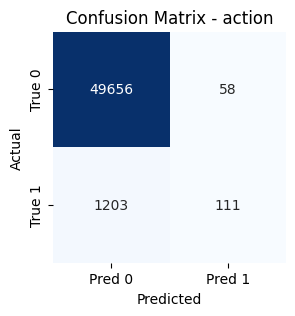

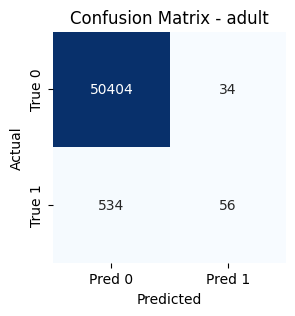

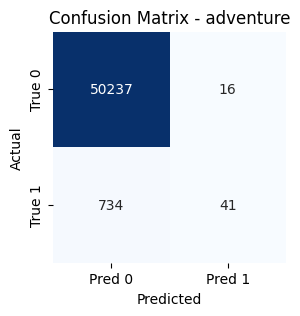

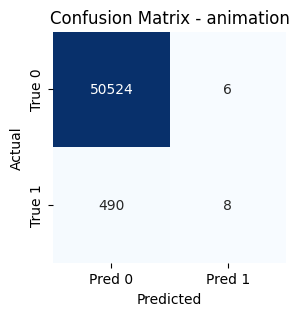

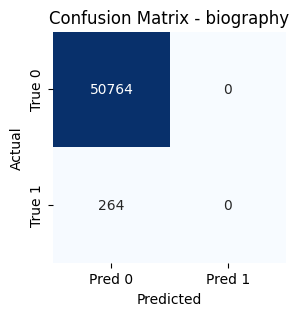

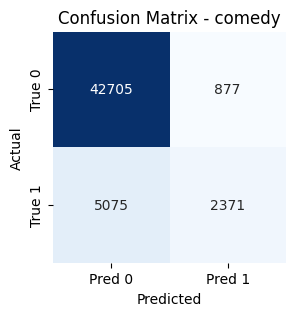

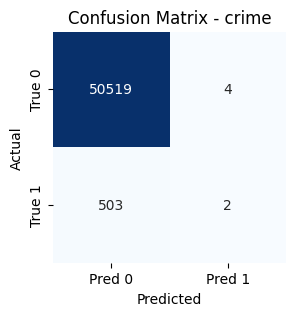

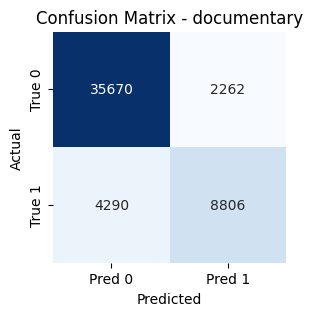

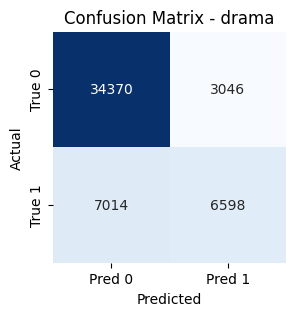

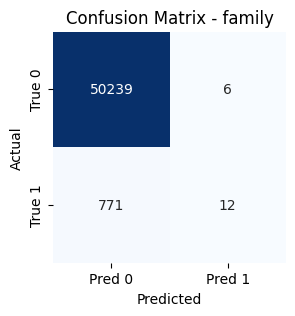

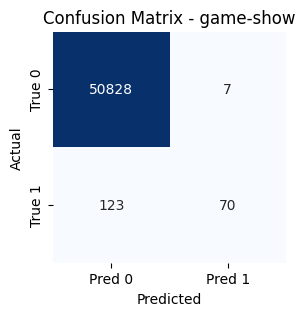

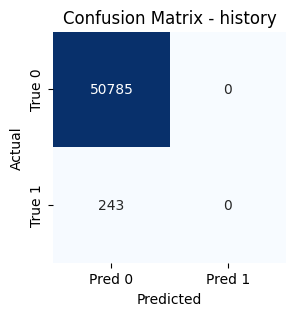

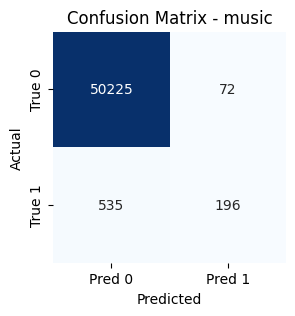

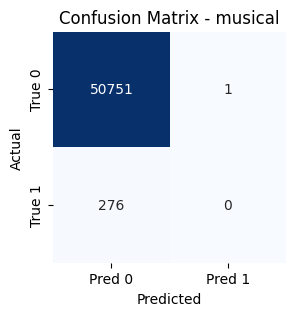

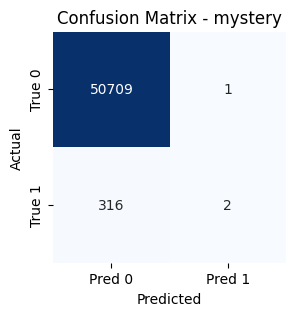

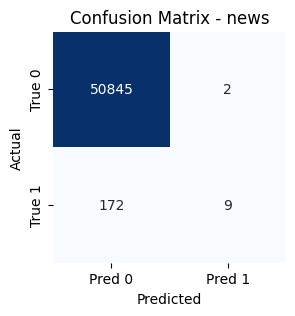

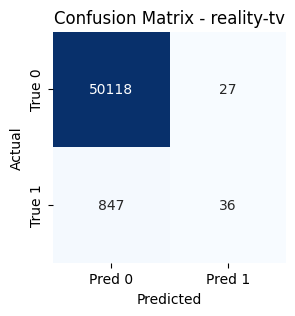

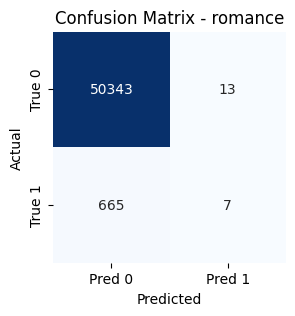

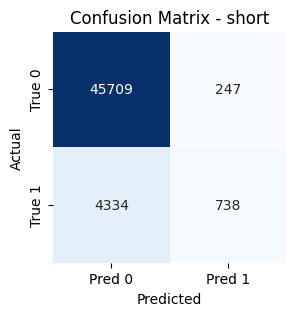

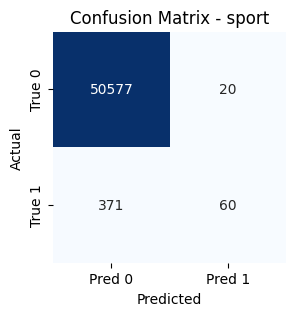

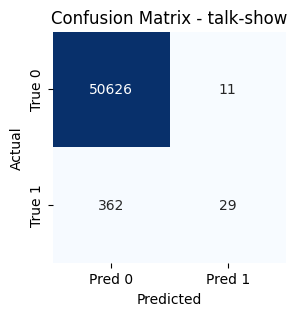

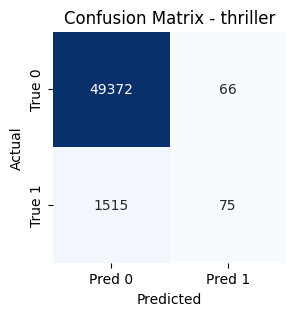

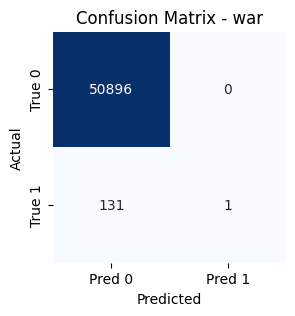

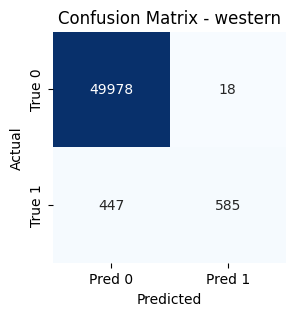

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix

# Multi-label confusion matrix
cm = multilabel_confusion_matrix(y_test, y_pred, labels=range(len(mlb.classes_)))

# Plot tiap label
for i, label in enumerate(mlb.classes_):
    plt.figure(figsize=(3,3))
    sns.heatmap(cm[i], annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"],
                yticklabels=["True 0", "True 1"])
    plt.title(f"Confusion Matrix - {label}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


<h4>7.2 Bar Chart Precision/Recall/F1 per Label</h4>

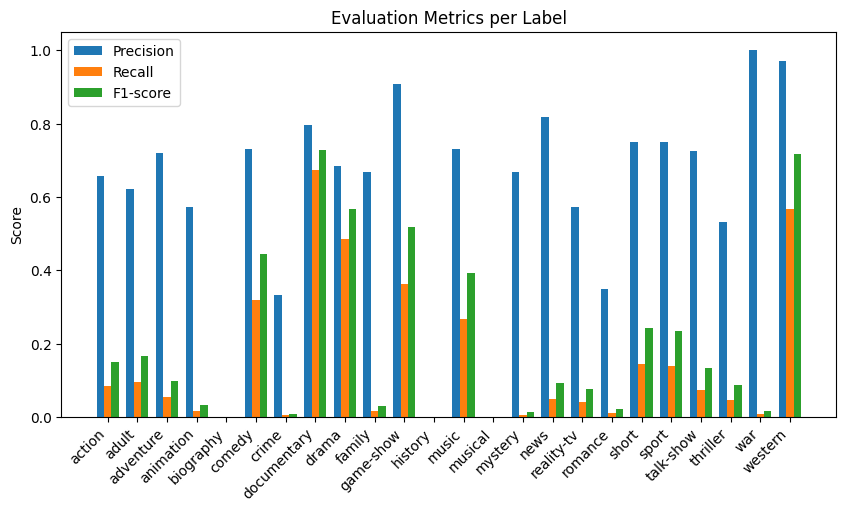

In [30]:
from sklearn.metrics import precision_recall_fscore_support

prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

plt.figure(figsize=(10,5))
x = range(len(mlb.classes_))
plt.bar(x, prec, width=0.25, label="Precision")
plt.bar([i+0.25 for i in x], rec, width=0.25, label="Recall")
plt.bar([i+0.5 for i in x], f1, width=0.25, label="F1-score")
plt.xticks([i+0.25 for i in x], mlb.classes_, rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Evaluation Metrics per Label")
plt.legend()
plt.show()


<h4>7.3 Label Distribution (Ground Truth vs Prediction)</h4>

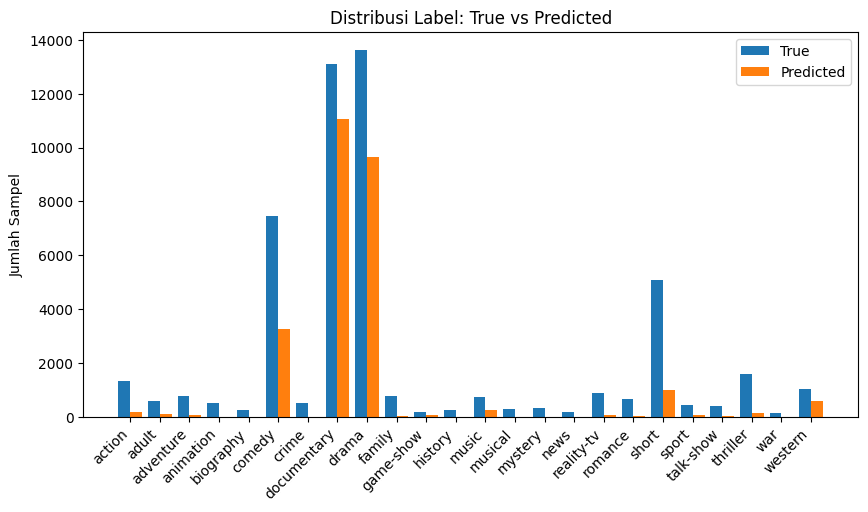

In [31]:
import numpy as np

true_counts = np.sum(y_test, axis=0)
pred_counts = np.sum(y_pred, axis=0)

plt.figure(figsize=(10,5))
x = np.arange(len(mlb.classes_))
plt.bar(x-0.2, true_counts, width=0.4, label="True")
plt.bar(x+0.2, pred_counts, width=0.4, label="Predicted")
plt.xticks(x, mlb.classes_, rotation=45, ha="right")
plt.ylabel("Jumlah Sampel")
plt.title("Distribusi Label: True vs Predicted")
plt.legend()
plt.show()


<h4>7.4 ROC Curve (Receiver Operating Characteristic) Per Label</h4>

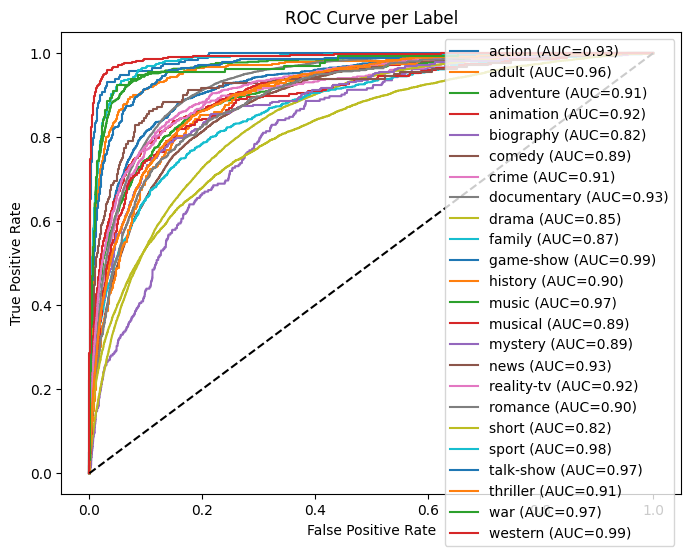

In [28]:
from sklearn.metrics import roc_curve, auc

y_prob = log_reg_model.predict_proba(X_test_tfidf)  # ambil probabilitas

plt.figure(figsize=(8,6))
for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC={roc_auc:.2f})")

plt.plot([0,1], [0,1], "k--")  # garis diagonal
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve per Label")
plt.legend()
plt.show()


<h4>7.5 Precision-Recall Curve</h4>

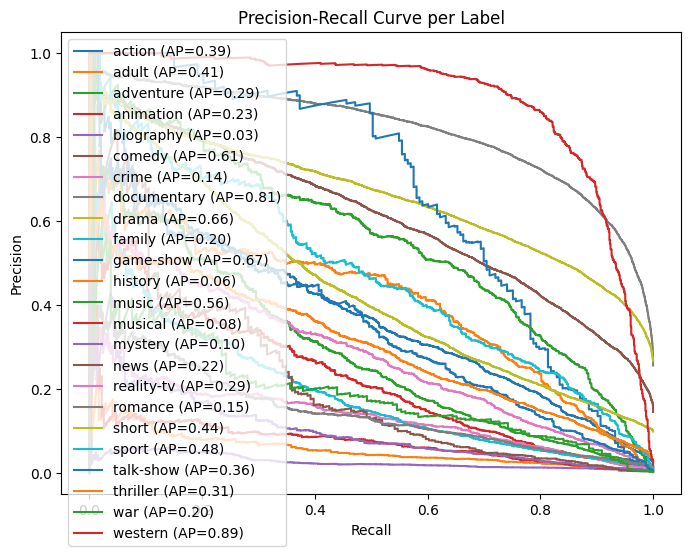

In [29]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8,6))
for i, label in enumerate(mlb.classes_):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    ap = average_precision_score(y_test[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"{label} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve per Label")
plt.legend()
plt.show()


<h4>7.6 Heatmap Co-occurrence (Label Bersamaan)</h4>

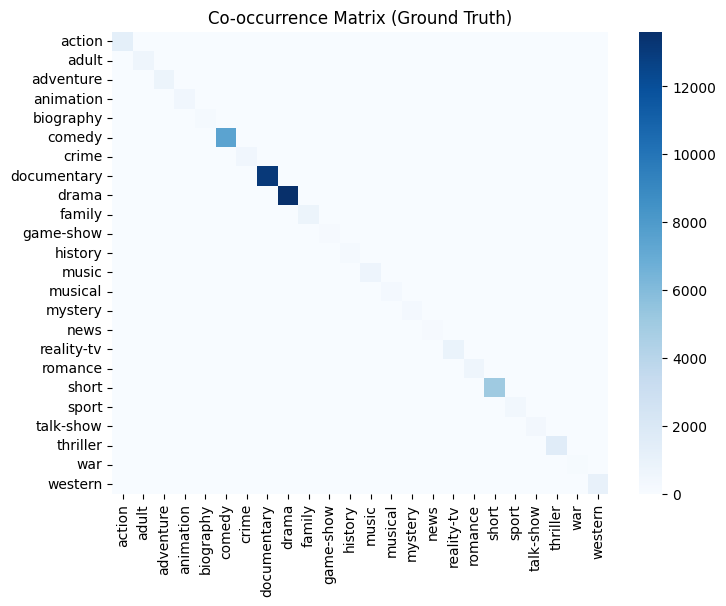

In [32]:
import numpy as np

# Hitung co-occurrence matrix (ground truth)
co_occ_true = np.dot(y_test.T, y_test)

plt.figure(figsize=(8,6))
sns.heatmap(co_occ_true, annot=False, cmap="Blues", xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Co-occurrence Matrix (Ground Truth)")
plt.show()


<h4>7.7 t-SNE / PCA Visualisasi Embedding TF-IDF</h4>

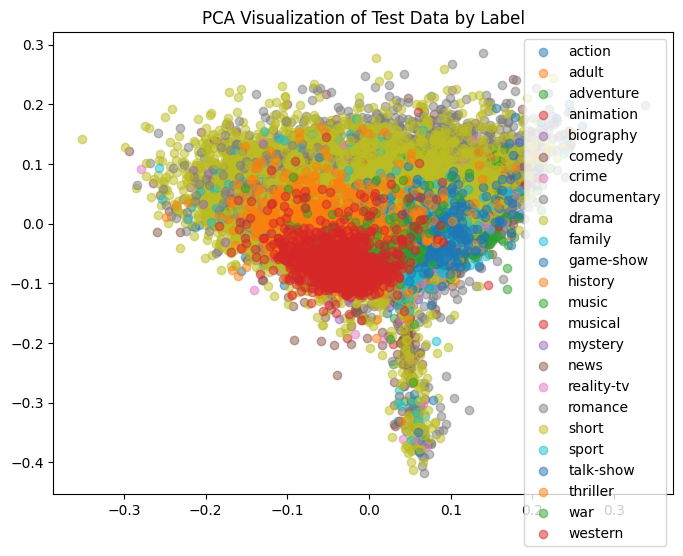

In [33]:
from sklearn.decomposition import PCA

X_reduced = PCA(n_components=2).fit_transform(X_test_tfidf.toarray())

plt.figure(figsize=(8,6))
for i, label in enumerate(mlb.classes_):
    plt.scatter(X_reduced[y_test[:, i]==1, 0],
                X_reduced[y_test[:, i]==1, 1],
                label=label, alpha=0.5)
plt.title("PCA Visualization of Test Data by Label")
plt.legend()
plt.show()


<h1>8. Save Model</h1>

In [35]:
import joblib

joblib.dump(log_reg_model, "result/lr_model.pkl")
joblib.dump(tfidf, "result/tfidf_vectorizer.pkl")
joblib.dump(mlb, "result/multilabel_binarizer.pkl")

print("Semua model dan encoder berhasil disimpan ✅")


Semua model dan encoder berhasil disimpan ✅
